In [1]:
from Bio.PDB import *
from Bio.PDB.DSSP import DSSP
from Bio.PDB.DSSP import dssp_dict_from_pdb_file
from Bio import SeqIO

import pickle
import os
from os import path
from os.path import isfile, join, dirname, isdir, exists

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy.linalg as linalg
from scipy import sparse
import scipy.signal
from snf import *

def getUnweightedLaplacianEigsDense(W):
    D = sparse.dia_matrix((W.sum(1).flatten(), 0), W.shape).toarray()
    L = D - W
    try:
        _, v = linalg.eigh(L)
    except:
        return np.zeros_like(W)
    return v

def get_csm(X, Y):
    if len(X.shape) == 1:
        X = X[:, None]
    if len(Y.shape) == 1:
        Y = Y[:, None]
    C = np.sum(X**2, 1)[:, None] + np.sum(Y**2, 1)[None, :] - 2*X.dot(Y.T)
    C[C < 0] = 0
    return np.sqrt(C)


def csm_to_binary(D, kappa):
    N = D.shape[0]
    M = D.shape[1]
    if kappa == 0:
        return np.ones_like(D)
    elif kappa < 1:
        NNeighbs = int(np.round(kappa*M))
    else:
        NNeighbs = kappa
    J = np.argpartition(D, NNeighbs, 1)[:, 0:NNeighbs]
    I = np.tile(np.arange(N)[:, None], (1, NNeighbs))
    V = np.ones(I.size)
    [I, J] = [I.flatten(), J.flatten()]
    ret = sparse.coo_matrix((V, (I, J)), shape=(N, M), dtype=np.uint8)
    return ret.toarray()

def csm_to_binary_mutual(D, kappa):
    return csm_to_binary(D, kappa)*(csm_to_binary(D.T, kappa).T)

def sliding_window(dist, win):
    N = D.shape[0]
    dist_stack = np.zeros((N-win+1, N-win+1))
    for i in range(0, win):
        dist_stack += dist[i:i+N-win+1, i:i+N-win+1]
    for i in range(N-win+1):
        dist_stack[i, i] = 0
    return dist_stack

def make_dir(*argv):
    mydir = path.join(*argv)    
    if not path.exists(mydir):        
        if len(argv) > 1:
            make_dir(*argv[:-1])            
        os.mkdir(mydir)
    return mydir


def make_path(*argv):
    mypath = path.join(*argv)
    if not path.exists(dirname(mypath)):
        make_dir(*argv[:-1])
    return mypath    

In [3]:
with open('pickles/LRRPred_validation.pickle', 'rb') as handle:
    LRR_d = pickle.load(handle)

df = pd.read_excel('FileS1.xlsx', skiprows = 9)
pdbl = PDBList()
code_l = []
for ii in range(df.shape[0]):
    if ii%2:
        code = df.iloc[ii]['PDB ID + chain']
        code_l.append(code)


In [4]:
# io = PDBIO()
# for code, val in LRR_d.items():
#     locs,chain = val
#     io.set_structure(chain)
#     io.save(make_path('pdb', 'validation_chains', code+'.pdb'))

In [5]:
for code in code_l:
    motifLocs = LRR_d[code]

    parser = PDBParser()
    structure = parser.get_structure(code, "pdb/validation_chains/%s.pdb"%code)

    chain = list(structure.get_chains())[0]


    csvpath = make_path('csv', 'validation', '%s.csv'%code)
    alpha_carbons = []
    for atom in chain.get_atoms():
        if atom.id == 'CA':
            alpha_carbons.append(np.array(list(atom.get_vector())))
            
    X = np.array(alpha_carbons)
    np.savetxt(csvpath, X, delimiter=',')

    #print out the number of residues in the chain, and print the locations of the LRR motif residues

    old_shape = X.shape[0]
    try:
        X = X[int(motifLocs[0]*.9):int(motifLocs[-1]*1.1), :]
    except:
        continue
    print(old_shape, X.shape)
    print(motifLocs)

    if X.shape[0] < 50:
        continue

    D = get_csm(X, X)
    # Clean up the matrix a bit by doing a sliding window of length roughly the period
    period = 25
    D = sliding_window(D, period)
    # Clean up the matrix even more by binarizing it with nearest neighbors
    B = csm_to_binary_mutual(D, 20)
    #B = B[0:400, 0:400]
    v = getUnweightedLaplacianEigsDense(1-B)
    with open('npy/validation_eigenmatrix/%s.npy'%code, 'wb') as f:
        np.save(f, v[:, 0:29])

    plt.figure(figsize=(18, 6))
    plt.subplot(131)
    plt.imshow(D, cmap='magma_r')
    plt.title("Self-Similarity Matrix")
    plt.subplot(132)
    plt.imshow(B)
    plt.title("Binarized Self-Similarity Matrix")
    plt.subplot(133)
    plt.imshow(v[:, 0:29], aspect='auto', cmap='magma_r', interpolation='none')
    plt.title("Eigenvectors of Unweighted Graph Laplacian")
    plt.savefig('plots/validation_eigenmatrix/%s.png'%code)
    # plt.show()
    plt.close()

162
[19, 42, 64, 88, 113, 140]
308
[42, 64, 86, 108, 130, 152, 174, 196, 218]
166
[18, 47, 75, 103, 133]
358
[39, 59, 79, 99, 121, 141, 163, 183, 205, 225, 245]
463
[45, 67, 89, 111, 133, 155, 176, 198, 220, 242]
313
[51, 77, 102, 126, 150, 175, 198, 222, 245]
284
[12, 33, 57, 81, 106, 130, 154, 178, 202, 226, 254]
266
[11, 32, 56, 78, 101, 125, 149, 173, 196]
167
[16, 45, 73, 101, 132]
189
[9, 30, 55, 79, 103, 127]
308
[5, 28, 65, 92, 118, 146, 170, 198, 225, 250]
263
[42, 64, 86, 107, 129, 151, 173]
305
[11, 32, 56, 80, 101, 125, 151, 172, 196, 220, 243]
629
[2, 23, 47, 71, 95, 119, 143, 169, 193, 220, 246]
325
[42, 65, 88, 113, 137, 163, 190, 217, 242]
456
[25, 53, 82, 110, 139, 167, 196, 224, 253]
343
[-1, 32, 60, 94, 122, 159, 187, 216, 244, 274, 303, 332]
168
[25, 50, 72, 96, 121, 148]
304
[10, 31, 55, 79, 100, 124, 149, 170, 194, 218, 241]
470
[12, 33, 57, 81, 105, 129, 153, 177, 201, 225, 249]
347
[9, 32, 57, 81, 104]
164
[18, 43, 65, 89, 114, 141]
270
[17, 38, 62, 86, 110, 134

IndexError: list index out of range

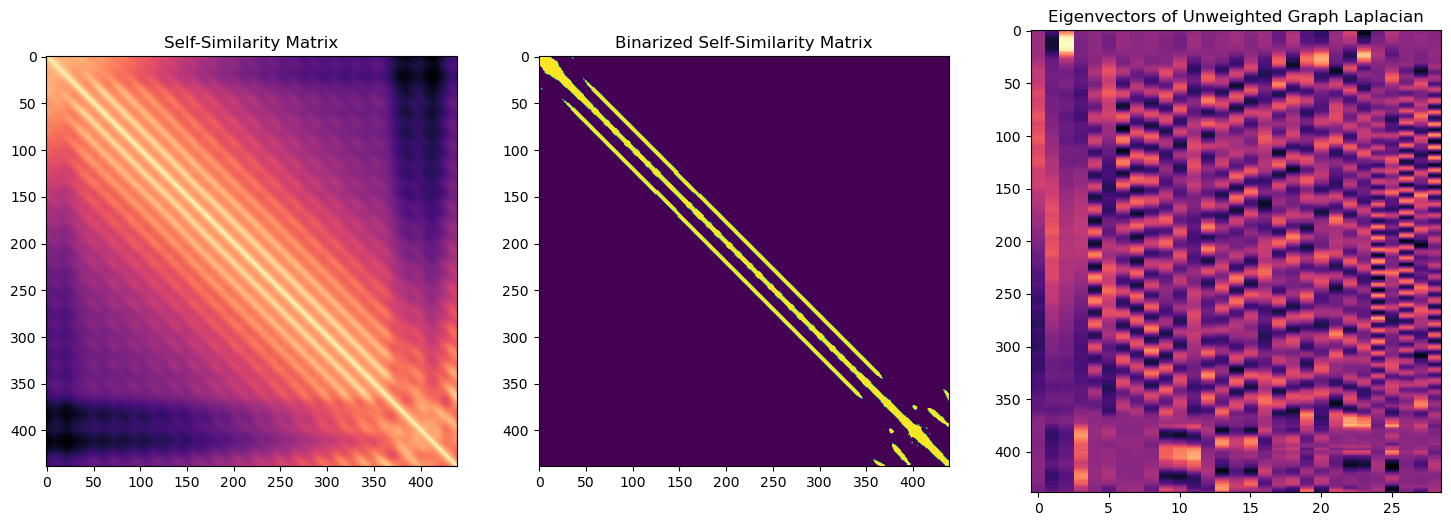

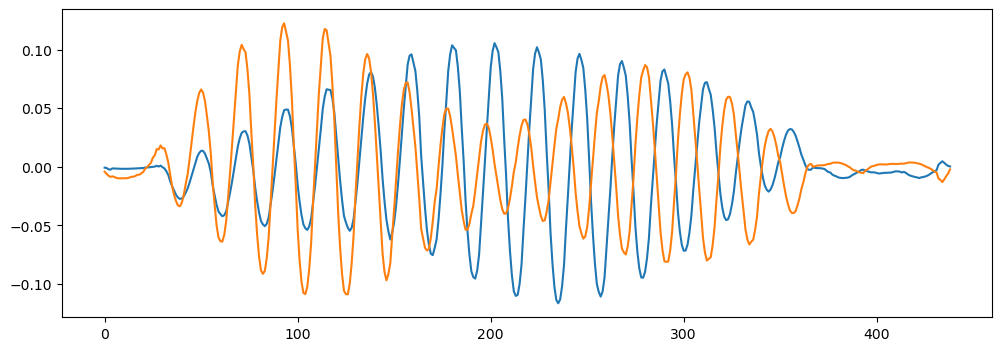

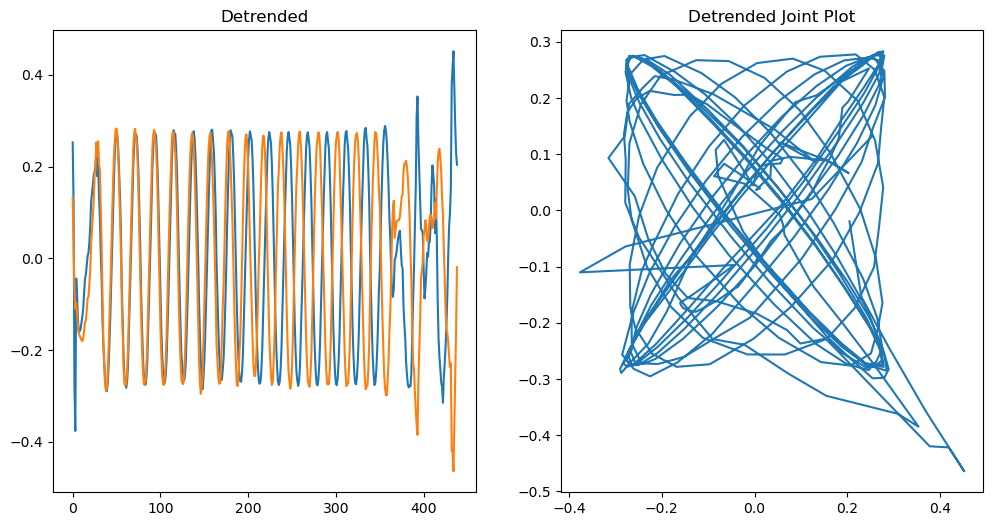

0



/var/folders/m0/rpw4gcbn5lxd8_3kt7g699rc0000gn/T/ipykernel_42107/3485565096.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(res, theta[res], 'bo', color='red')


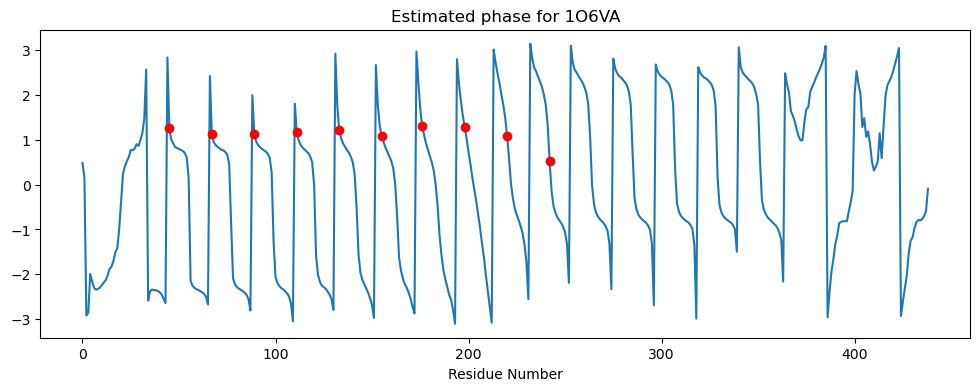

<function matplotlib.pyplot.close(fig=None)>

In [20]:
# I can see the signal in the 5th and 6th eigenvectors
# but it needs to be demodulated
plt.figure(figsize=(12, 4))
s = v[:,4]
c = v[:, 6]
plt.plot(s)
plt.plot(c)
plt.show()
from daps import *
# Detrend with daps
sf = detrend_timeseries(s, period)
cf = detrend_timeseries(c, period)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(sf)
plt.plot(cf)
plt.title("Detrended")
plt.subplot(122)
plt.title("Detrended Joint Plot")
plt.plot(sf, cf)
plt.show()


# Extract the final phase and plot

theta = np.arctan2(cf, sf)
plt.figure(figsize=(12, 4))
plt.plot(theta)

omitted = 0
for res in motifLocs:
    if res < len(theta):
        plt.plot(res, theta[res], 'bo', color='red')                  
    else:
        omitted += 1
print(omitted)        


plt.title("Estimated phase for %s" %code)
plt.xlabel("Residue Number")
plt.savefig(make_path('plots','validation/%s.png'%code))
print()

plt.show()
plt.close